In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats
import cartopy.feature as cfeature

import shapely.vectorized as sv

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm

import shapely.geometry as sg
from shapely.geometry import Point

from sklearn.linear_model import LinearRegression

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

from playsound import playsound

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## Mean of Seeds

In [2]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

italy_geom = ITALY.union_all()

## Original QUANTILES DOWNSCALED

In [3]:
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_ENSEMBLE')

dir_in = os.path.join(ENS_base,f'ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median.nc')
DATA = xr.open_dataset(dir_in)
lon2d, lat2d, = np.meshgrid(DATA.lon, DATA.lat)
mask_italy = sv.contains(italy_geom, lon2d, lat2d)

MEVd_Median = DATA.Mev_d.where(mask_italy)

## OBS data

In [4]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

Tr = [5,  10,  20,  50, 100, 200]
Fi = 1 - 1/np.array(Tr)

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

obs_base = os.path.join('/','media','arturo','T9','Data','Italy','Rain_Gauges_QC')
bias_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','TEST')

METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

ISO_names = np.unique(METADATA.ISO.values)

lats, lons = [], []
QUANTILE = []

for rr in range(len(ISO_names)):
    region_ISO = ISO_names[rr]

    INFO_dict = {}
    WEIBULL_dict = {}
    QUANTILES_dict = {}

    # print(f'{rr+1}: {region_ISO}')

    METADATA_clear = METADATA[METADATA['ISO']==region_ISO].reset_index(inplace=False)

    for nn in range(len(METADATA_clear)):#len(METADATA_clear)
        filename = f'{METADATA_clear['File'].values[nn]}'
        lat_obs = METADATA_clear['Lat'][nn]
        lon_obs = METADATA_clear['Lon'][nn]
        elev_obs = METADATA_clear['DEM_Elevation'][nn]

        OBS_pd = pd.read_csv(os.path.join(obs_base, 'Weibull', '1dy', region_ISO, filename))
        OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)
        
        if len(OBS_pd) == 0:
            continue

        else:
            OBS_N = OBS_pd['N'].values
            OBS_C = OBS_pd['C'].values
            OBS_W = OBS_pd['W'].values
            OBS_Y = OBS_pd['Year'].values

            mask = ~np.isnan(OBS_N)

            OBS_N = OBS_N[mask]
            OBS_C = OBS_C[mask]
            OBS_W = OBS_W[mask]
            OBS_Y = OBS_Y[mask]

            if len(OBS_Y) >= 8: # greather than 8 years

                x0 = np.nanmean(OBS_C)
                OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
                OBS_Q2 = np.where(flag, OBS_Q, np.nan)

                lats.append(lat_obs)
                lons.append(lon_obs)
                QUANTILE.append(OBS_Q2[3])

Quantile_pd = pd.DataFrame({'lat':lats,'lon':lons,'Quantile':QUANTILE})
Quantile_clear = Quantile_pd[Quantile_pd['Quantile']<500]
Q_norm = (Quantile_clear['lat'].values - np.nanmin(Quantile_clear['lat'].values))/(np.nanmax(Quantile_clear['lat'].values)-np.nanmin(Quantile_clear['lat'].values)) *2

## CORRECTION DATA

In [5]:
seeds_list = [7, 19, 31, 53, 89, 127, 211, 307, 401, 509, 613, 727, 839, 947, 1051]
# seeds_list = [7, 19, 31]

In [6]:
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','QUANTILE')

MEVd_Median_QQc = np.zeros([len(seeds_list),240,260])
MEVd_Median_LLc = np.zeros([len(seeds_list),240,260])

nn = 0
for seed in seeds_list:
    print(f'Seed: {seed}')
    dir_in = os.path.join(ENS_base,f'ITALY_DOWN_ENSEMBLE_median_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc_LLc_{str(seed).zfill(4)}.nc')
    DATA = xr.open_dataset(dir_in)
    mask_italy = sv.contains(italy_geom, lon2d, lat2d)

    MEVd_Median_QQc[nn,:,:] = DATA.MEVd_QQc.where(mask_italy)
    MEVd_Median_LLc[nn,:,:] = DATA.MEVd_LLc.where(mask_italy)
    
    nn = nn + 1

# Median of all seeds
MEVd_QQc = np.nanmedian(MEVd_Median_QQc,axis=0)
MEVd_LLc = np.nanmedian(MEVd_Median_LLc,axis=0)

Seed: 7
Seed: 19
Seed: 31
Seed: 53
Seed: 89
Seed: 127
Seed: 211
Seed: 307
Seed: 401
Seed: 509
Seed: 613
Seed: 727
Seed: 839
Seed: 947
Seed: 1051


In [7]:
dir_in = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_RE_{str(seed).zfill(4)}.csv')
DF_RE = pd.read_csv(dir_in)

dir_in = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_stats_QQc_{str(seed).zfill(4)}.csv')
RSR_DOWN_QQc = pd.read_csv(dir_in)

dir_in = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_stats_LLc_{str(seed).zfill(4)}.csv')
RSR_DOWN_LLc = pd.read_csv(dir_in)

In [8]:
dir_in = os.path.join('/','media','arturo','T9','Data','Italy','Bias_series','QUANTILES',f'Bias_RE_{str(seed).zfill(4)}.csv')
DF_RE = pd.read_csv(dir_in)

dfs = []

ENSEMBLE_group = np.zeros([len(seeds_list), 808])

nn = 0
for seed in seeds_list:
    print(f'Seed: {seed}')
    
    tmp = pd.read_csv(dir_in)
    ENSEMBLE_group[nn,:] = tmp.ENSEMBLE_MEDIAN_QQc.values

    dir_in = os.path.join(
        '/', 'media', 'arturo', 'T9', 'Data', 'Italy',
        'Bias_series', 'QUANTILES',
        f'Bias_RE_{str(seed).zfill(4)}.csv')

    dfs.append(pd.read_csv(dir_in))
    
    nn = nn + 1

data_stack = np.stack([df.values for df in dfs], axis=0)
data_median = np.nanmedian(data_stack, axis=0)
DF_median = pd.DataFrame(
    data_median,
    columns=dfs[0].columns
)

Seed: 7
Seed: 19
Seed: 31
Seed: 53
Seed: 89
Seed: 127
Seed: 211
Seed: 307
Seed: 401
Seed: 509
Seed: 613
Seed: 727
Seed: 839
Seed: 947
Seed: 1051


In [9]:
seed = seeds_list[2]
dir_in = os.path.join(
        '/', 'media', 'arturo', 'T9', 'Data', 'Italy',
        'Bias_series', 'QUANTILES',
        f'Bias_RE_{str(seed).zfill(4)}.csv')
test = pd.read_csv(dir_in)

In [10]:
test

,IMERG,IMERG_QQc,IMERG_LLc,CMORPH,CMORPH_QQc,CMORPH_LLc,MSWEP,MSWEP_QQc,MSWEP_LLc,ERA5,...,ERA5_LLc,GSMaP,GSMaP_QQc,GSMaP_LLc,CHIRPS,CHIRPS_QQc,CHIRPS_LLc,ENSEMBLE_MEDIAN,ENSEMBLE_MEDIAN_QQc,ENSEMBLE_MEDIAN_LLc
0,0.300580,0.313825,0.342906,0.190410,-0.008989,0.156878,-0.224467,-0.005684,0.127712,-0.077418,...,0.228873,-0.434382,-0.082860,0.061257,-0.044165,0.175003,0.266904,-0.198661,-0.009050,0.072159
1,-0.239752,-0.363687,-0.268669,0.062299,-0.101865,-0.001033,-0.256370,-0.030595,0.032521,-0.525224,...,-0.358718,-0.399540,0.016946,0.083495,-0.186757,0.023741,0.060120,-0.405567,-0.316619,-0.216358
2,0.234948,0.074096,0.206480,NaN,NaN,NaN,-0.076493,0.184672,0.349499,NaN,...,NaN,-0.154985,0.377477,0.540589,-1.000000,-0.400212,-0.960483,-0.079414,0.082396,0.218532
3,-0.318340,-0.303896,-0.294099,-0.325587,-0.431812,-0.362305,-0.298516,0.028704,-0.115318,-0.484978,...,-0.315601,-0.704425,-0.521883,-0.446189,-0.450807,-0.284288,-0.292510,-0.455877,-0.217650,-0.232275
4,0.957872,0.943823,1.013811,0.679901,0.390385,0.673390,0.295415,0.673236,0.842322,-0.034981,...,0.300923,-0.079178,0.495685,0.713108,0.498834,0.842883,0.973877,0.226926,0.517318,0.641516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,0.233170,0.191053,0.259996,-0.182438,-0.251978,-0.111652,0.092260,0.553257,0.452956,-0.017587,...,0.305769,-0.356319,0.047568,0.185200,0.044432,0.336835,0.349005,-0.192470,0.003042,0.083452
804,-0.347351,-0.096050,-0.277202,-0.035506,0.461690,-0.261541,-0.330394,0.093423,-0.216562,-0.464978,...,-0.297189,-0.640179,-0.205583,-0.373921,-0.620184,-0.517170,-0.507146,-0.453571,0.003927,-0.174933
805,-0.217442,-0.176329,-0.185564,-0.503154,-0.561417,-0.466391,-0.276882,0.052021,-0.067993,-0.128831,...,0.143361,-0.468877,0.109502,-0.067187,-0.084673,0.621873,0.059485,-0.351666,-0.013800,-0.074558
806,-0.256873,0.290620,-0.145604,-0.508336,-0.588226,-0.543827,-0.459318,-0.168548,-0.338324,NaN,...,NaN,-0.575004,0.139292,-0.280644,-0.404579,0.188009,-0.322759,-0.453193,0.018906,-0.168277


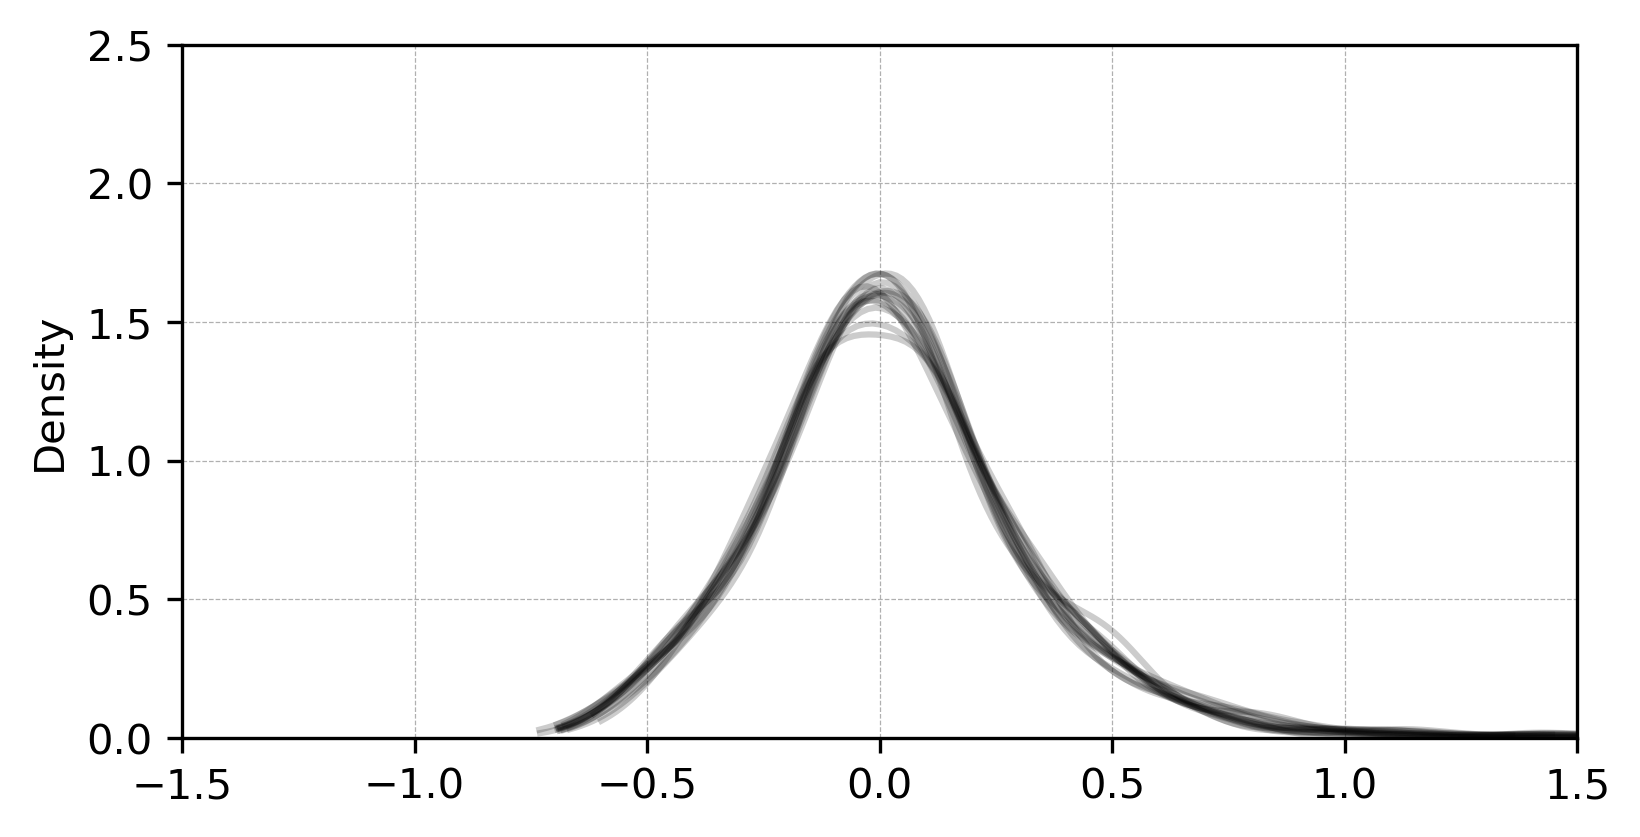

In [11]:
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ===========================================================================================================================================================================
# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 0])

for nn in range(len(seeds_list)):

    sns.kdeplot(ENSEMBLE_group[nn,:],color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(ENSEMBLE_group[nn,:])), np.nanmax(np.array(ENSEMBLE_group[nn,:]))), alpha=0.2)

# sns.kdeplot(test.ENSEMBLE_MEDIAN_QQc,color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
#             clip=(np.nanmin(np.array(test.ENSEMBLE_MEDIAN_QQc)), np.nanmax(np.array(DF_median.ENSEMBLE_MEDIAN_QQc))))

# sns.kdeplot(DF_median.ENSEMBLE_MEDIAN_QQc,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
#             # clip=(np.nanmin(np.array(DF_median.ENSEMBLE_MEDIAN_QQc)), np.nanmax(np.array(DF_median.ENSEMBLE_MEDIAN_QQc))))
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.grid(linewidth=0.3, linestyle='--')

## Lo correcto seria calcular el MEVD medio de QQc Y LLc respectivamente y a ese nuevo producto medio calcularle los errores relativos

In [13]:
# sys.exit()

In [31]:
# Mev_levels = np.arange(60, 390, 10)
Mev_levels = np.arange(40, 320, 10)

Mev_cmap = plt.cm.Spectral_r
norm = BoundaryNorm(Mev_levels, ncolors=Mev_cmap.N, clip=True)

colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

colors_T = [colors[0], colors[2], colors[3], 'k', 
            colors[0], colors[2], colors[3], 'k',]

markers_T = ['o', 'o', 'o', 'o', '^', '^', '^', '^']

../figures/Article_down/Bias_correction_QUANTILES_ALL.png


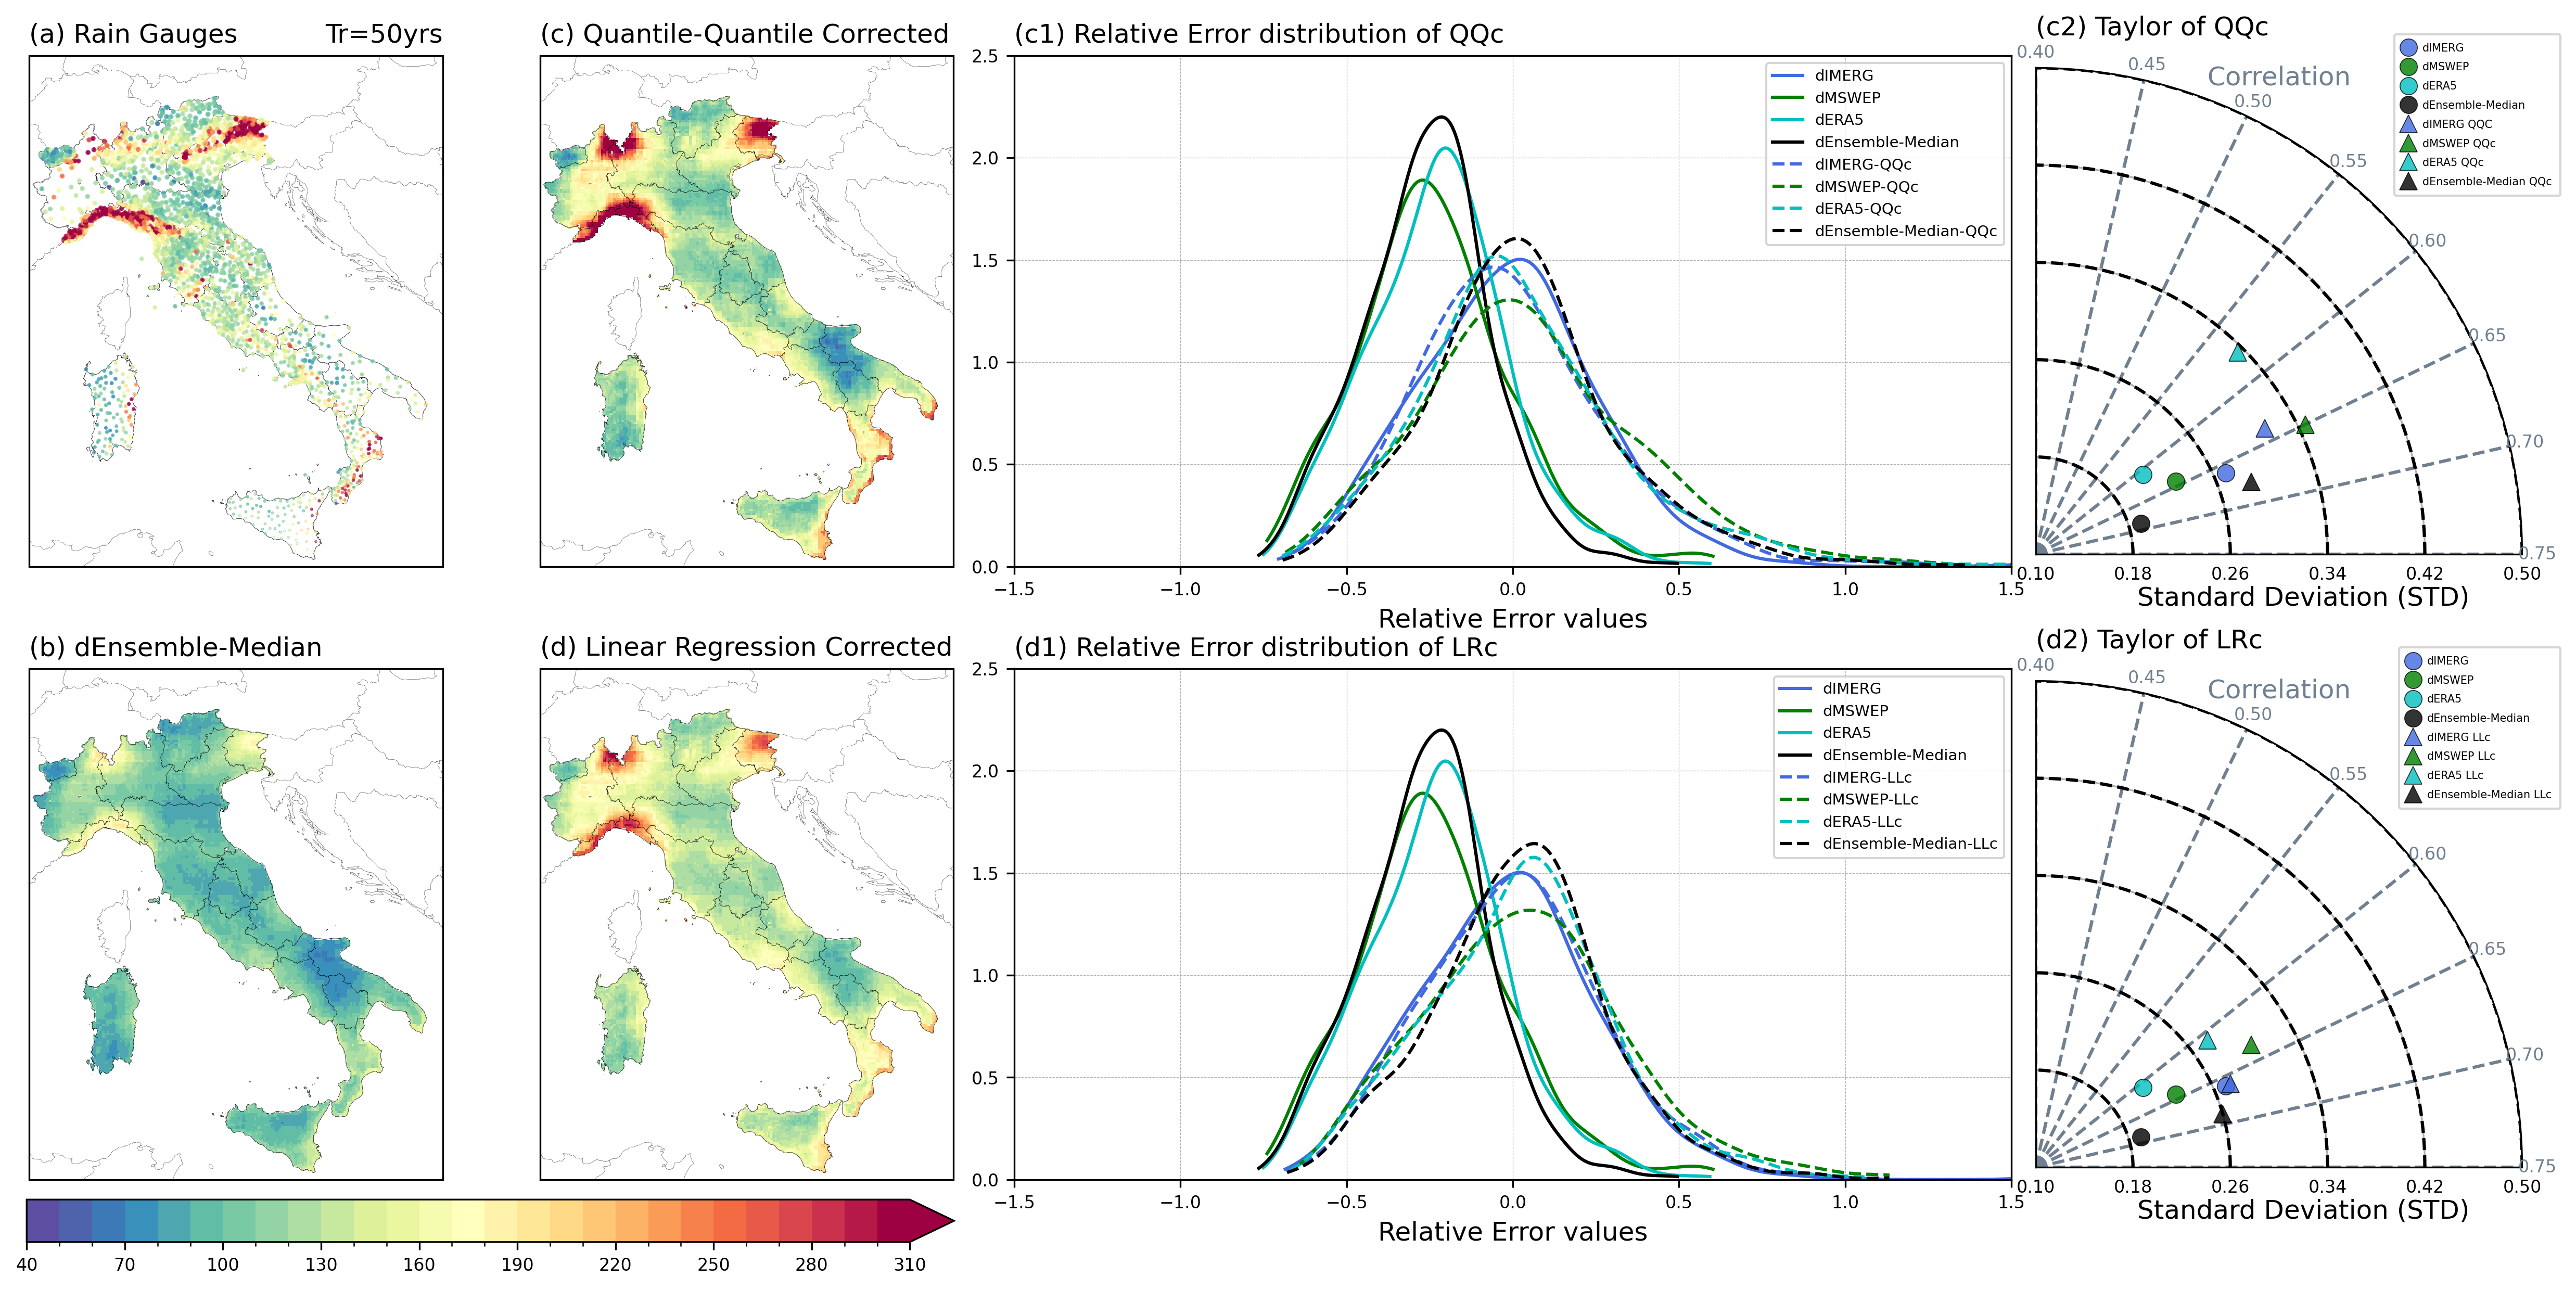

In [32]:
pos = 3

proj = ccrs.PlateCarree()

Mev_cmap = plt.cm.Spectral_r
diff_map = plt.cm.coolwarm_r
norm = mcolors.BoundaryNorm(boundaries=Mev_levels, ncolors=Mev_cmap.N)
# norm_diff = mcolors.BoundaryNorm(boundaries=Diff_levels, ncolors=diff_map.N)

fig = plt.figure(figsize=(18,8),dpi=300)
gs = gridspec.GridSpec(2,5)

# ===========================================================================================================================================================================
# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.1,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
a1 = ax1.scatter(Quantile_clear['lon'].values, Quantile_clear['lat'].values, c=Quantile_clear['Quantile'].values, s=Q_norm, alpha=0.8,cmap=Mev_cmap,norm=norm, zorder=10)

ax1.set_title('(a) Rain Gauges', loc='left', fontsize=12)
ax1.set_title('Tr=50yrs', loc='right', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.1,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_QQc, cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(c) Quantile-Quantile Corrected', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 2:4])
ax1.set_aspect('auto')
sns.kdeplot(DF_RE.IMERG,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_RE.IMERG)), np.nanmax(np.array(DF_RE.IMERG))))
sns.kdeplot(DF_RE.MSWEP,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_RE.MSWEP)), np.nanmax(np.array(DF_RE.MSWEP))))
sns.kdeplot(DF_RE.ERA5,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_RE.ERA5)), np.nanmax(np.array(DF_RE.ERA5))))
sns.kdeplot(DF_RE.ENSEMBLE_MEDIAN,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_RE.ENSEMBLE_MEDIAN)), np.nanmax(np.array(DF_RE.ENSEMBLE_MEDIAN))))

sns.kdeplot(DF_RE.IMERG_QQc,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-QQc',
            clip=(np.nanmin(np.array(DF_RE.IMERG_QQc)), np.nanmax(np.array(DF_RE.IMERG_QQc))))
sns.kdeplot(DF_RE.MSWEP_QQc,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-QQc',
            clip=(np.nanmin(np.array(DF_RE.MSWEP_QQc)), np.nanmax(np.array(DF_RE.MSWEP_QQc))))
sns.kdeplot(DF_RE.ERA5_QQc,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-QQc',
            clip=(np.nanmin(np.array(DF_RE.ERA5_QQc)), np.nanmax(np.array(DF_RE.ERA5_QQc))))
sns.kdeplot(DF_RE.ENSEMBLE_MEDIAN_QQc,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-QQc',
            clip=(np.nanmin(np.array(DF_RE.ENSEMBLE_MEDIAN_QQc)), np.nanmax(np.array(DF_RE.ENSEMBLE_MEDIAN_QQc))))

ax1.set_ylabel('',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_title('(c1) Relative Error distribution of QQc', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 4], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_DOWN_QQc.STD.values, RSR_DOWN_QQc.CORR.values, RSR_DOWN_QQc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.set_title('(c2) Taylor of QQc', loc='left', fontsize=12, pad=15)

# ===========================================================================================================================================================================
# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.1,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_Median[pos,:,:], cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(b) dEnsemble-Median', loc='left', fontsize=12)


# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.1,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_LLc, cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(d) Linear Regression Corrected', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 2:4])

sns.kdeplot(DF_RE.IMERG,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_RE.IMERG)), np.nanmax(np.array(DF_RE.IMERG))))
sns.kdeplot(DF_RE.MSWEP,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_RE.MSWEP)), np.nanmax(np.array(DF_RE.MSWEP))))
sns.kdeplot(DF_RE.ERA5,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_RE.ERA5)), np.nanmax(np.array(DF_RE.ERA5))))
sns.kdeplot(DF_RE.ENSEMBLE_MEDIAN,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_RE.ENSEMBLE_MEDIAN)), np.nanmax(np.array(DF_RE.ENSEMBLE_MEDIAN))))

sns.kdeplot(DF_RE.IMERG_LLc,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-LLc',
            clip=(np.nanmin(np.array(DF_RE.IMERG_LLc)), np.nanmax(np.array(DF_RE.IMERG_LLc))))
sns.kdeplot(DF_RE.MSWEP_LLc,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-LLc',
            clip=(np.nanmin(np.array(DF_RE.MSWEP_LLc)), np.nanmax(np.array(DF_RE.MSWEP_LLc))))
sns.kdeplot(DF_RE.ERA5_LLc,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-LLc',
            clip=(np.nanmin(np.array(DF_RE.ERA5_LLc)), np.nanmax(np.array(DF_RE.ERA5_LLc))))
sns.kdeplot(DF_RE.ENSEMBLE_MEDIAN_LLc,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-LLc',
            clip=(np.nanmin(np.array(DF_RE.ENSEMBLE_MEDIAN_LLc)), np.nanmax(np.array(DF_RE.ENSEMBLE_MEDIAN_LLc))))

ax1.set_ylabel('',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_title('(d1) Relative Error distribution of LRc', loc='left', fontsize=12)

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 4], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_DOWN_LLc.STD.values, RSR_DOWN_LLc.CORR.values, RSR_DOWN_LLc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.set_title('(d2) Taylor of LRc', loc='left', fontsize=12, pad=15)

# ===========================================================================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.05, hspace=0.2)

cbar_ax = fig.add_axes([0.062, 0.0, 0.33, 0.034])
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=8)

# cbar_ax = fig.add_axes([0.66, 0.09, 0.29, 0.038])
# cbar = fig.colorbar(a2, cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=8)

# ===========================================================================================================================================================================
salida = '../figures/Article_down/Bias_correction_QUANTILES_ALL.png'
print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)